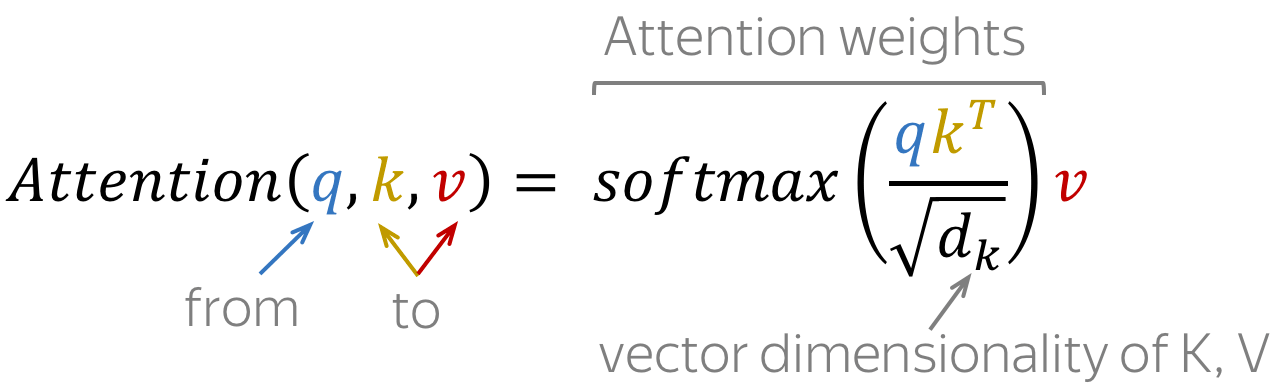

Self attention - is a memory mechanizm, which makes elements of data (it could be tokens of text or patches of images) to "look" on other ones and define, which of them is the most important for final representation. For example, let it be a matrix X with N elements and each element of which is describe by D vector, so X ∈ R^(N x D). Then we need to extracr three matrices from X: 
- Q (for "query") - matrix with elements, we should pay attention on
- K (for "keys") - matrix with descriptions of elements, which are compared to Q-matrix
- V (for "values") - matrix with elements, which will be handled.

So, (Q,K,V) ∈ R^(N×D).Then, we should put K into form of K ∈ R^(D×N) with reshaping. After that we couldmultiply matrices Q and K to let each element of Q to "look" on each element of "K". Thus we define which elements suit for query better. We also deivide this matrix on √D (vector of X matrix) to prevent gradient explosion. Then we apply softmax function for (Q * K) / √D to turn it into attention probability distribution for each patch or token. And finally, we multiply attention matrix on V ("values") matrix to aggregate contextual information from all elements in the V sequence (or patches in an image for example), weighted by their relevance (as determined by the attention matrix).

Full formula is noted above.


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=64, heads=1):
        super().__init__()
        
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.heads = heads

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.to_q = nn.Linear(embed_dim, embed_dim)
        self.to_k = nn.Linear(embed_dim, embed_dim)
        self.to_v = nn.Linear(embed_dim, embed_dim)

        self.to_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # x has size of [B, C, H, W]
        x = self.proj(x)  
    
        x = x.flatten(2)  
        # this will put x size into [B, C, H*W], so [B, C, N], where N = H * W
        
        x = x.transpose(1, 2) 
        # and this will put x of size [B, C, N] into [B, N, C]


        # here we form Q, K and V matrixes
        Q = self.to_q(x)      
        K = self.to_k(x)      
        V = self.to_v(x)      

        # realisation of formula A(Q, K, V) = softmax((Q * K) / √D) * V
        
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5) 

        attn = F.softmax(scores, dim=-1) 

        out = torch.matmul(attn, V) 
        
        # and finally we may form output of size [B, N, C] (which lately could be transposed).
        out = self.to_out(out)

        return out


In [12]:
x = torch.randn(1, 3, 32, 32)

model = AttentionBlock(in_channels=3, patch_size=4, embed_dim=64)
out = model(x)  
print(out.shape)

torch.Size([1, 64, 64])


In [13]:
# this is realisation of transposing of output of attention block, which then could be passed into 
# other layers 

model = AttentionBlock(in_channels=3, patch_size=4, embed_dim=64)
out = model(x) 
out = out.transpose(1, 2).reshape(-1, 64, 8, 8)
print(out.shape)

torch.Size([1, 64, 8, 8])


In [20]:
# Non-linear realisation with residual elements:

class ConvSABlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.q = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.k = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.v = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # parameter, which will be optimizer by NN 
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        Q = self.q(x).view(B, -1, H*W).permute(0, 2, 1)  # B, C, N -> B, N, C
        K = self.k(x).view(B, -1, H*W)   # B, C, N
        V = self.v(x).view(B, -1, H*W).permute(0, 2, 1)  # B, C, N -> B, N, C
        
        d_k = Q.size(-1)
        
        attention = torch.bmm(Q, K) / d_k ** 0.5
        attention = F.softmax(attention, dim=-1)
        
        out = torch.bmm(attention, V)
        out = out.permute(0, 2, 1).view(B, C, H, W)
        
        # gamma represents, how we could relay on out of attention (out)
        return self.gamma * out + x 
        
        

In [22]:
block = ConvSABlock(64)
tensor = torch.randn(1, 64, 32, 32)

out = block(tensor)
print(out.shape)

torch.Size([1, 64, 32, 32])
